# Attentive State-space Models

### A complete guide for using attentive state-space models for sequential, time-series data.

This notebook is based on the paper *"Attentive State-Space Modeling of Disease Progression"* by *Ahmed M. Alaa* and *Mihaela van der Schaar* submitted to **NeurIPS 2019**. In this paper, we develop a deep probabilistic model that learns accurate and interpretable structured representations for disease trajectories. Unlike Markovian state-space models, in which the dynamics are memoryless, our model uses an attention mechanism to create "memoryful" dynamics, whereby attention weights determine the dependence of future disease states on past medical history. In what follows, we briefly explain the basic API for the Python (Tensorflow) implementation of the model, and provide examples for how to use.

### A brief explanation of the model

An attentive state-space model is a deep probabilistic model that capitalizes on both the interpretable structured representations of probabilistic models and the predictive strength of deep learning methods. The model uses a state-space representation to segment an observable trajectory into hidden states. But unlike conventional state-space models, which are predominantly Markovian, we use RNNs to capture more complex state dynamics as shown in the figure below.

![](images/comparison.png)

**Sequential data models.** (a) Graphical model for an RNN. Diamonds denote a deterministic representation, (b) Graphical model for an HMM: circles denote probabilistic states, (c) Graphical depiction of an attentive state space model. With a slight abuse of graphical model notation, thickness of arrows reflect attention weights. Because the attention mechanism can be made arbitrarily complex, our model can capture complex dynamics while maintaining its structural interpretability. The attention mechanism is implemented via a sequence-to-sequence RNN architecture.

### Setting up the experiment 

In what follows, we use a synthetic dataset to train an attentive state-space model and display the learned model parameters. Before we start, we need to import two libraries:

- **data.make_data**: the file containing the synthetic data generation model.
- **models.SeqModels**: the file containing the attentive state-space model.

In [4]:
from data.make_data import generate_trajectory
from models.SeqModels import attentive_state_space_model as attentive_state_space

import numpy as np

We start by drawing random, variable-sized trajectories from the synthetic data model using the function **generate_trajectory** as follows

In [2]:
X_observations, true_states = generate_trajectory(num_states=3, 
                                                  Num_observations=10, 
                                                  Num_samples=5000, 
                                                  Max_seq=30, 
                                                  Min_seq=3, 
                                                  alpha=100,
                                                  reverse_mode=False)

The synthetic data model uses hidden states to generate observations. The return variables **X_observations** and **true_states** correspond to the observable variables and the hidden state trajectories. Our model is given only the observable data, and should be able to learn the underlying state trajectory that generated the data. The synthetic data generation function takes the following 6 arguments:

- **num_states:** The cardinality of the hidden state space.
- **Num_observations:** The number of observable variables (i.e., emissions, or features) that are associated with each state.
- **Num_samples:** The total number of state trajectories to simulate.
- **Max_seq, Min_seq:** The minimum and maximum number of obervations per trajectory. For each trajectory, the sequence length is drawn from a uniform distribution [Min_seq, Max_seq]
- **alpha:** This is a real number that determines the extent of "memory" in the state trajectory. The contribution of each state realized at time $t$ (for a sequence of length $T$) on the current state transition is proportion to $e^{-\alpha (T-t)}$. Hence, the effect of alpha can be understood through the following extreme cases:

    1. $\alpha$ = $\infty$: Then only the current state determines the next state. This corresponds to a Markov model where transitions are completely memorlyess. Here we set $\alpha=100$ which makes it very close to a Markov chain.
    
    2. $\alpha$ = $0$: In this case, all previous states are equally important, in which cases the model needs to attend to very old state realizations in order to predict future state transitions. 


- **reverse_mode:** This is a boolean that determines whether the importance is higher for more recent or older state realizations. When it is set to *True*, the importance of previous states are set to $e^{-\alpha (t-T)}$. In this case, setting $\alpha$ = $\infty$ makes the initial state the only factor that determines all state transitions, irrespective of any inetrmediate states.

The observations are determined by state-dependent Gaussian distributions, the parameters of which can also be changed, but we will not need to change these during this Tutorial.

## Visualizing the true data trajectories

Both the variables **X_observations** and **true_states** are in the forms of lists, the size of which correspond to the number of trajectories that we simulated. Each list contains a variable-length sequence of observations and states. Let us see whatsequence of states is realized in the first trajectory:

In [25]:
trajectory_index = 0

true_states[trajectory_index]

[0, 1, 0, 2, 1, 2, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 1, 2, 1, 0, 2, 1, 0, 0, 2, 1]

Because we set the state-space to contain only three states, the true states can take on values in the set $\{0,1,2\}$. Now let us visualize the first trajectory by overlaying the hidden states and the observable variables in one plot.

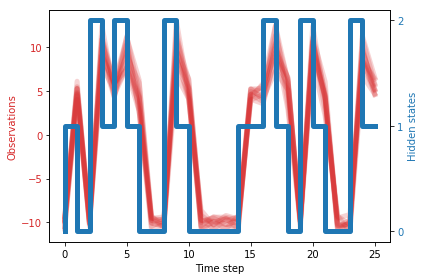

In [26]:
from matplotlib import pyplot as plt
get_ipython().magic('matplotlib inline')

fig, ax1 = plt.subplots()

t = list(range(len(true_states[trajectory_index])))

color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('Observations', color=color)
ax1.plot(t, X_observations[trajectory_index], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Hidden states', color=color)  
ax2.step(t, true_states[trajectory_index], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

In [ ]:
Here, the blue plot reflects the underlying hidden states that generates the observations, and as we can see, the states modulate the distribution of the observable variables (red). The attentive state-space model should be able to do the following:

- Learn an underlying representation for the data in terms of a state space and emission distribution.
- Predict the state and observations trajectories.
- Uncover the memory dynamics underlying the state transitions.
- Generate synthetic samples that mimic those of the original data distribution.

## Training attentive state-space models

We first instantiate an attentive state space model object as follows:

In [5]:
model = attentive_state_space(num_states=3,
                              maximum_seq_length=30, 
                              input_dim=10, 
                              rnn_type='LSTM',
                              latent=True,
                              generative=True,
                              num_iterations=50, 
                              num_epochs=3, 
                              batch_size=100, 
                              learning_rate=5*1e-4, 
                              num_rnn_hidden=100, 
                              num_rnn_layers=1,
                              dropout_keep_prob=None,
                              num_out_hidden=100, 
                              num_out_layers=1)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.




The attentive state-space model takes on the following arguments:

- **num_states**: The number of states in the state space.
- **maximum_seq_length**: The maximum allowable length for any trajectory in the training data. 
- **input_dim**: The number of observations/features in every time step.
- **rnn_type**: The type of RNN used in model and inference networks. Select from (LSTM, GRU, RNN)
- **latent, generative**: (Redundant) Whether state labels are provided, and whether the model is generative (can sample trajectories).
- **num_iterations, num_epochs, batch_size, learning_rate**: Variational inference learning parameters.
- **num_rnn_hidden, num_rnn_layers**: Number of hidden states/layers of all RNNs in the model.
- **dropout_keep_prob**: Whether dropout is used for regularization.
- **num_out_hidden, num_out_layers**: Number of hidden states/layers of output layers.

To train the model, we provide a simple sklearn-like API where the model is fit by simply providing the list of observations to the fit method of the attentative state-space object as follows:

In [6]:
model.fit(X_observations)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

TensorFlow version : >= 1.0
---------------------------

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




Epoch 0 	----- 	Batch 2 	----- 	Log-Likelihood -1.698948e+02 	----- Acc 0.4389
Epoch 1 	----- 	Batch 2 	----- 	Log-Likelihood -2.707021e

Now that the model is trained, we display the parameters of the representation it learned. The initial state and transition probabilities can be recovered by inspecting the attributes of **model** as follows:

In [0]:
model.initial_probabilities

The initial distribution exactly matches that of the synthetic model, which has an initial state distribution of [0.5, 0.3, 0.2]. The baseline state transition matrix of the attentive state-space models is given by:

In [0]:
model.transition_matrix

The emission distributions for all states are assumed to be Gaussian. The mean and covariance parameters of the three states can be recovered as follows:

In [0]:
model.state_means.T 

In [0]:
model.state_covars

## Predicting state trajectories via attentive state-space models

To use our model for prediction, we again provide an sklearn-like API where the model issues prediction by simply providing the list of observations to the predict method of the attentative state-space object as follows:

In [12]:
state_inference, expected_observations, attention = model.predict([X_observations[0]])

INFO:tensorflow:Restoring parameters from ./mlaimRNN_model


In [8]:
The predict method retrieves three different variables: 

- **state_inference**: This is the posterior distribution over the "future" states given previous observations, i.e. $P(X_{t+1}| X_t,.\,.\,., X_0)$. For the returned vector, every element corresponds to a time step $t$, and the values is the distribution of the future states (for the next time step $t+1$). 
- **expected_observations**: The expected values of the observation in the next time step $t+1$.
- **attention**: The attention weights assigned to all previous hidden states to issue the current prediction.

SyntaxError: invalid syntax (<ipython-input-8-b39deec40579>, line 1)

The maximum a posteriori (MAP) estimates of the inferred states can be obtained by picking the most likely state per time step as follows:

In [20]:
trajectory_index = 1

IndexError: list index out of range

In [18]:
np.argmax(state_inference[0], axis=-1)

0

In what follows, we visually compare the MAP state estimates with the true states:

In [0]:
fig, ax1 = plt.subplots()

trajectory_index = 0

t = list(range(len(true_states[trajectory_index])))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('MAP state estimate', color=color)
ax1.plot(t, np.argmax(state_inference[trajectory_index], axis=1), color=color, linewidth=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0, 1, 2])

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('True states', color=color)  
ax2.step(t, true_states[trajectory_index], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

We also visually compare the expected observation estimates with the true observations:

In [0]:
fig, ax1 = plt.subplots()

t = list(range(len(true_states[trajectory_index])))

color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('True observations', color=color)
ax1.plot(t, X_observations[trajectory_index], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Predicted average observations', color=color)  
ax2.plot(t, expected_observations[trajectory_index], color=color, linewidth=5, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

## Visualizing the attention weights over time

Now, in what follows, we visualize the attention weights materializing at every time-step for the trajectory above. As we can see, because the true underlying model is Markovian, we can see that the biggest attention weight is almost always placed on the most recent time-step.

In [0]:
import seaborn as sns

Attention_weights = []

for w in range(len(attention[0])):
    
    Attention_weights.append(np.vstack((attention[0][w], np.zeros((len(attention[0][-1]) - len(attention[0][w]),1)))))


Attention_weights = np.array(Attention_weights).reshape((len(attention[0][-1]), len(attention[0][-1])))[:state_inference[0].shape[0], :state_inference[0].shape[0]]

mask = np.zeros_like(Attention_weights)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(Attention_weights, mask=mask, vmax=.3, square=True)
    ax.set_ylabel('Chronological time')
    ax.set_xlabel('Previous time steps')

## Sampling from the (generative) attentive state-space model

Because our model is generative, we can also sample new (synthetic) trajectories from the model. This means that our model can be used for generating synthetic data. To sample from the trained model, we can use the **sample** API as follows:

In [0]:
sampled_states, sampled_obervations  = model.sample(trajectory_length=5)

In the above, the **trajectory_length** parameter decides the number of states materializing in the sampled sequence. In what follows, we visualize the sampled states and observations.

In [0]:
from matplotlib import pyplot as plt
get_ipython().magic('matplotlib inline')

fig, ax1 = plt.subplots()

t = list(range(len(sampled_states)))

color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('Sampled observations', color=color)
ax1.plot(t, sampled_obervations[0], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Sampled hidden states', color=color)  
ax2.step(t, sampled_states, color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

## What is the effect of memory on the attention mechanism?

Now we look at a different synthetic datasets where we use the reverse mode of the generative synthetic model to assign bigger importance weight on older states. We take an extreme case where the initial states controls all state transitions along the trajectory (see the earlier explanation for the synthetic data.)

In [0]:
X_observations_new, true_states_new = generate_trajectory(num_states=3, 
                                                          Num_observations=10, 
                                                          Num_samples=5000, 
                                                          Max_seq=30, 
                                                          Min_seq=3, 
                                                          alpha=100,
                                                          reverse_mode=True)

We then fit a new model on this new dataset...

In [0]:
model_new = attentive_state_space(num_states=3,
                                  maximum_seq_length=30, 
                                  input_dim=10, 
                                  rnn_type='LSTM',
                                  latent=True,
                                  generative=True,
                                  num_iterations=50, 
                                  num_epochs=3, 
                                  batch_size=100, 
                                  learning_rate=5*1e-4, 
                                  num_rnn_hidden=100, 
                                  num_rnn_layers=1,
                                  dropout_keep_prob=None,
                                  num_out_hidden=100, 
                                  num_out_layers=1)

In [0]:
model_new.fit(X_observations_new)

In [0]:
state_inference_new, expected_observations_new, attention_new = model_new.predict([X_observations_new[0]])

Now let us visualize the attention weights materializing over time for the new model...

In [0]:
import seaborn as sns

Attention_weights = []

for w in range(len(attention_new[0])):
    
    Attention_weights.append(np.vstack((attention_new[0][w], np.zeros((len(attention_new[0][-1]) - len(attention_new[0][w]),1)))))


Attention_weights = np.array(Attention_weights).reshape((len(attention_new[0][-1]), len(attention_new[0][-1])))[:state_inference[0].shape[0], :state_inference[0].shape[0]]

mask = np.zeros_like(Attention_weights)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(Attention_weights, mask=mask, vmax=.3, square=True)
    ax.set_ylabel('Chronological time')
    ax.set_xlabel('Previous time steps')

As we can see, unlike in the previous case, here we have most of the attention weights assigned to the older states! Thus, our attentive state-space model learned the underlying state dynamics in an unsupervised fashion on the basis of the observed data.